In [1]:
import cv2
import math
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from PIL import Image
#import imquality.brisque as brisque
#from pdf2image import convert_from_path
#import PyPDF2
from pytesseract import Output
import pytesseract
from PIL import Image
import os
#import img2pdf

In [2]:
pwd

'/data/mmortgage/rotation'

In [3]:
def imgshow(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

In [4]:
convert_from_path('./DL.pdf', 
                  output_folder='./', 
                  fmt='jpeg',
                  output_file='DL',
                  thread_count=10)

NameError: name 'convert_from_path' is not defined

In [83]:
#im = Image.open('./eg12.jpg')
#brisque.score(im)

/data/mmortgage/rotation/rotation_env/lib/python3.6/site-packages/imquality/brisque.py:45: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  self.image = skimage.color.rgb2gray(self.image)


66.13955398963387

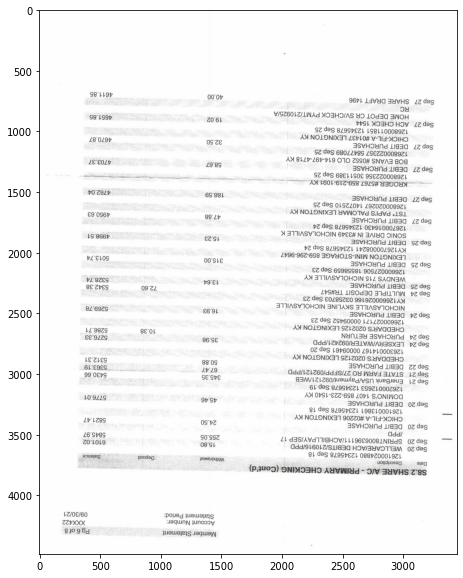

In [8]:
img = cv2.imread('./egg.jpg')
#img = np.asarray(img)
imgshow(img)

180


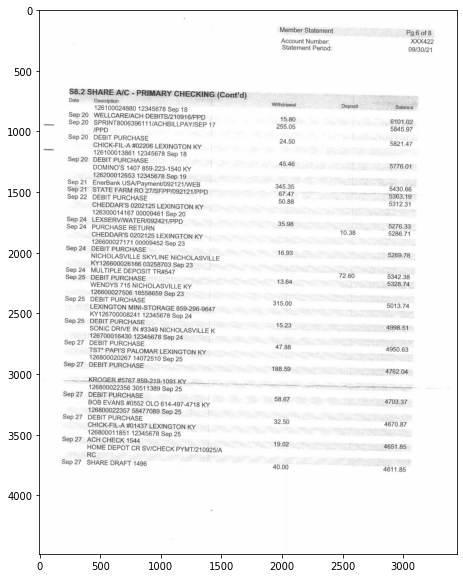

In [9]:
osd = pytesseract.image_to_osd(img, output_type=Output.DICT)
if osd['orientation']>180:
    angle = -osd['orientation']
else:
    angle = osd['orientation']
    
#if(angle==180):
#    angle=0
print(angle)
image = ndimage.rotate(img, angle)
imgshow(image)

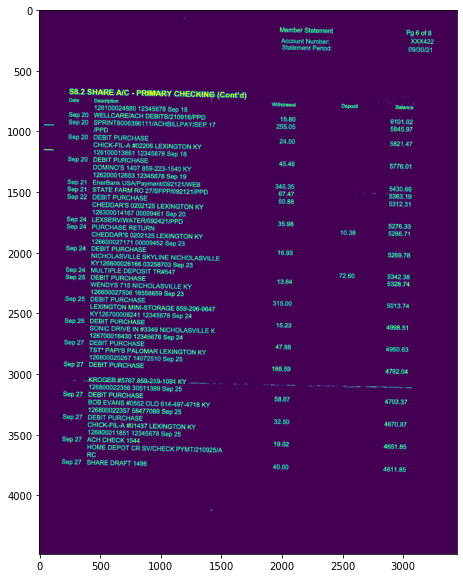

In [10]:
img = image.copy()
gry_img =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bw = cv2.threshold(gry_img, 127, 180, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
imgshow(bw)

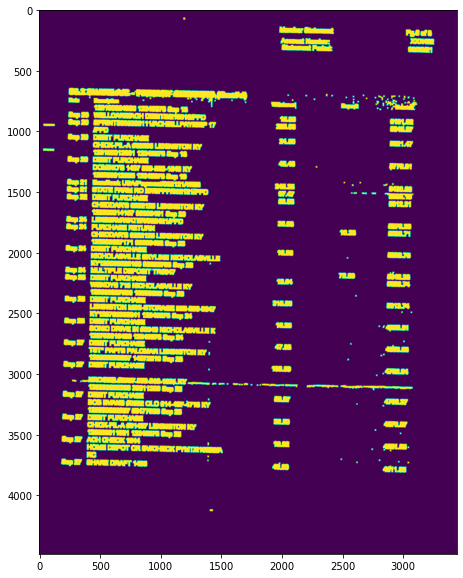

In [11]:
kernel = np.ones((5,5), np.uint8)
img_dilation = cv2.dilate(bw, kernel, iterations=3)
imgshow(img_dilation)

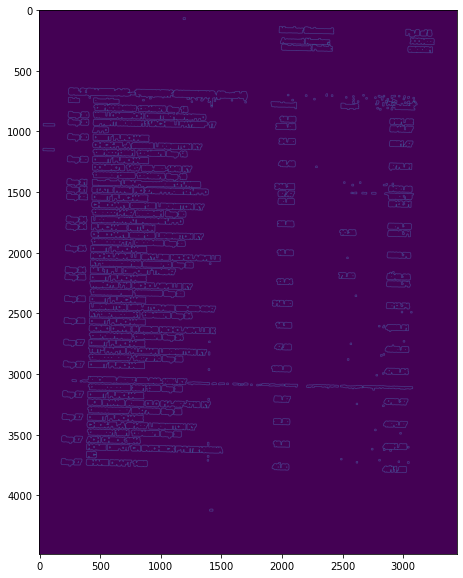

In [12]:
img_edges = cv2.Canny(img_dilation, 100, 100, apertureSize=3)
imgshow(img_edges)

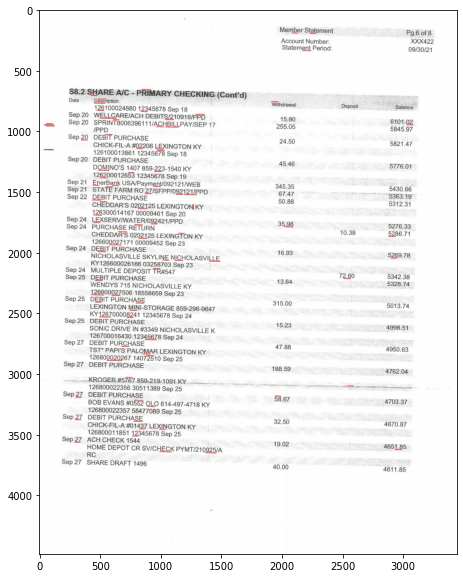

In [13]:
lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=50, maxLineGap=5)
angles = []
imgcp = image.copy()
for [[x1, y1, x2, y2]] in lines:
    cv2.line(imgcp, (x1, y1), (x2, y2), (255, 0, 0), 3)
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angles.append(angle)

imgshow(imgcp)

In [14]:
angels = sorted(angles, reverse=False)
#angels

In [15]:
median_angle = angels[int(len(angles)/2)-1]
median_angle

0.9240453527727062

In [16]:
np.median(angles)

0.9240453527727062

/tmp/ipykernel_10573/3579468713.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img_rotated = img.rotate(median_angle, Image.NEAREST, expand = 1, fillcolor = (255,255,255))


Angle is 1.0000


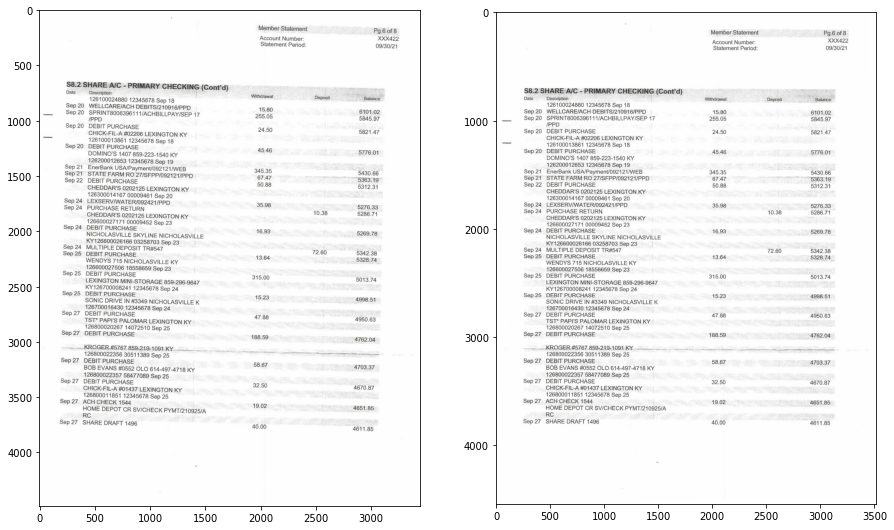

In [17]:
median_angle = np.round(np.median(angles))
img = Image.fromarray(np.uint8(image))
img_rotated = img.rotate(median_angle, Image.NEAREST, expand = 1, fillcolor = (255,255,255))
#img_rotated = ndimage.rotate(image, median_angle)
print(f"Angle is {median_angle:.04f}")
#cv2.imwrite('./egg_skew_PIL.jpg', np.array(img_rotated))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_rotated)

In [20]:
import cv2
import math
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
#import imquality.brisque as brisque
from pdf2image import convert_from_path
import PyPDF2
from pytesseract import Output
import pytesseract
import os
import img2pdf
from PIL import Image
import time
from io import BufferedReader, BytesIO

In [21]:
def pdf2image(filename):
    try:          
        convert_from_path(readpath, 
                          first_page=1, 
                          last_page=numpages,
                          output_folder=pdfImages, 
                          fmt='jpeg', 
                          thread_count=1)
        return pdfImages
        
    except Exception as e:
        print('Error pdf2image: ',str(e))
        return None

In [22]:
def pageSkewCorrection(image):
    gry_img =  cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_edges = cv2.Canny(gry_img, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
    angles = []
    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)
    median_angle = np.median(angles)
    img_rotated = ndimage.rotate(image, median_angle)
    return(img_rotated, median_angle)

In [23]:
def textAngleCoorection(image):
    osd = pytesseract.image_to_osd(image, output_type=Output.DICT)
    if osd['orientation']>180:
        angle = -osd['orientation']
    else:
        angle = osd['orientation']
    if(angle==180):
        angle=0
    image = ndimage.rotate(image, angle)
    return (image, angle)

In [204]:
'''IMAGEPATH = './image/'
OUTPATH = './corrected/'
for file in os.listdir(IMAGEPATH):
    image = cv2.imread(os.path.join(IMAGEPATH,file))
    img_rotated, angle = pageSkewCorrection(image)
    if(angle!=0):
        cv2.imwrite(os.path.join(OUTPATH, file.split('.')[0]+'_corrected.jpg'), img_rotated)'''

In [31]:
def rotationCorrection(imgPath):
    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, textangle = textAngleCoorection(image)
    image, pageangle = pageSkewCorrection(image)
    if((pageangle!=0) or (textangle!=0)):
        PILimage = Image.fromarray(image)
        PILimage.save(imgPath,quality=10,optimize=True)

In [37]:
IMAGEPATH = './corrected'
INPUT = './ADhoc_Sample_41_merged.pdf'
from concurrent.futures import ThreadPoolExecutor
import time

start_time = time.time()
pdfImages = os.path.join(IMAGEPATH, filename.split('.')[0])
os.makedirs(pdfImages, exist_ok=True)
convert_from_path(INPUT,
                  output_folder=pdfImages,
                  fmt='jpeg',
                  output_file=filename.split('.')[0],
                  thread_count=10)
images = []
for i,image in enumerate(sorted(os.listdir(pdfImages))):
    images.append(os.path.join(pdfImages,image))
    #rotationCorrection(os.path.join(pdfImages,image))
with ThreadPoolExecutor(10) as executor:
    executor.map(rotationCorrection,images)
print("--- %s seconds ---" % (time.time() - start_time))

--- 93.37519001960754 seconds ---


In [243]:
PDFPath = './pdf'
IMAGEPATH = './corrected'
filename = 'egExp.pdf'

pdfImages = os.path.join(IMAGEPATH, filename.split('.')[0])
os.makedirs(pdfImages, exist_ok=True)
try:
    readpath = os.path.join(PDFPath,filename)
    pdfFileObj = open(readpath, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    numpages = pdfReader.numPages
except Exception as e:
    print('PyPDF2 unable to read pdf: ', e)
    

convert_from_path(readpath,
                          first_page=1, 
                          last_page=numpages,
                          output_folder=pdfImages, 
                          fmt='jpeg', 
                          thread_count=1)
pdf_writer = PyPDF2.PdfFileWriter()

for i,image in enumerate(sorted(os.listdir(pdfImages))):
    flag=0
    imgPath = os.path.join(pdfImages,image)
    print(imgPath)
    image = cv2.imread(imgPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image, textangle = textAngleCoorection(image)
    image, pageangle = pageSkewCorrection(image)
    print('textangle: ',textangle)
    print('pageangle: ',pageangle, '\n')
    
    page = pdfReader.getPage(i)
    if((pageangle!=0) or (textangle!=0)):
        PILimage = Image.fromarray(image)
        PILimage.save(imgPath,quality=10,optimize=True)
        correctPDF = img2pdf.convert([imgPath])
        correctPDF = BufferedReader(BytesIO(correctPDF))
        correctedPDFReader = PyPDF2.PdfFileReader(correctPDF)
        page = correctedPDFReader.getPage(0)
    pdf_writer.addPage(page)
    
pdf_out = open('rotated.pdf', 'wb')
pdf_writer.write(pdf_out)
pdf_out.close()
pdfFileObj.close()

./correctedPDF/egExp/e5cf950c-3ee8-4ef2-9b06-f04d7673d35b-1.jpg
pageangle:  1.6731955428791245
textangle:  0
{'/Contents': IndirectObject(17, 0), '/MediaBox': [0, 0, 1239, 1614], '/Parent': IndirectObject(10, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(16, 0)}}, '/Type': '/Page'}


{'/Contents': IndirectObject(8, 0), '/MediaBox': [0, 0, 2678.25, 3437.25], '/Parent': IndirectObject(1, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(7, 0)}}, '/Type': '/Page'} 

./correctedPDF/egExp/e5cf950c-3ee8-4ef2-9b06-f04d7673d35b-2.jpg
pageangle:  -2.2457425658950716
textangle:  90
{'/Contents': IndirectObject(3, 0), '/MediaBox': [0, 0, 1650, 1275], '/Parent': IndirectObject(10, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(2, 0)}}, '/Type': '/Page'}


{'/Contents': IndirectObject(8, 0), '/MediaBox': [0, 0, 2789.25, 3539.25], '/Parent': IndirectObject(1, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(7, 0)}}, '/Type': '/Page'} 

./correctedPDF/egExp/e5cf950c-3ee8-4ef2-9b06-f04d7673d35b-3.jpg
pageangle:  0.0
textangle:  0
{'/Contents': IndirectObject(6, 0), '/MediaBox': [0, 0, 1275, 1650], '/Parent': IndirectObject(10, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(5, 0)}}, '/Type': '/Page'}
{'/Contents': IndirectObject(6, 0), '/MediaBox': [0, 0, 1275, 1650], '/Parent': IndirectObject(10, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(5, 0)}}, '/Type': '/Page'} 

./correctedPDF/egExp/e5cf950c-3ee8-4ef2-9b06-f04d7673d35b-4.jpg
pageangle:  0.0
textangle:  90
{'/Contents': IndirectObject(9, 0), '/MediaBox': [0, 0, 792, 612], '/Parent': IndirectObject(10, 0), '/Resources': {'/XObject': {'/Im0': IndirectObject(8, 0)}}, '/Type': '/Page'}
{'/Contents': IndirectObject(8, 0), '/MediaBox': [0, 0, 1275, 1650], '/Parent': 

In [176]:
imgs = [os.path.join(pdfImages,image) for image in os.listdir(pdfImages)]
type(img2pdf.convert(imgs))

bytes

In [178]:
type(pdfReader.getPage(0))

PyPDF2.pdf.PageObject

bytes

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg']

In [252]:
import img2pdf

with open("./egExp_r.pdf","wb") as f:
    f.write(img2pdf.convert(['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg']))

In [ ]:
'''gray = cv2.cvtColor(img_rotated, cv2.COLOR_BGR2GRAY)
_,binaryImage = cv2.threshold(filter, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
binaryImage = 255-binaryImage
imgshow(binaryImage)
np.unique(binaryImage)'''

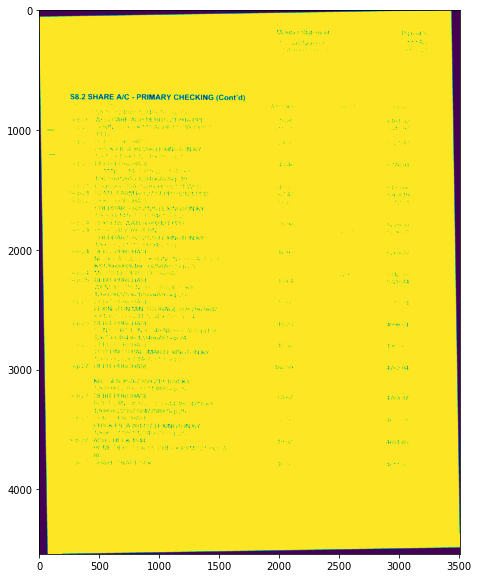

In [334]:
gray = cv2.cvtColor(img_rotated, cv2.COLOR_BGR2GRAY)
if gray.shape[0]>gray.shape[1]:
    div = gray.shape[0]
else:
    div = gray.shape[1]
    
kernel = np.ones((5,5), np.float32)/div
filter = cv2.filter2D(gray, -1, kernel)
_,binaryImage = cv2.threshold(filter, 250,255, cv2.THRESH_OTSU)
imgshow(binaryImage)

In [ ]:
'''temp = img_rotated.copy()
contours, hierarchy = cv2.findContours(binaryImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
#cnt = contours[1]
rect = cv2.minAreaRect(cnt) 
box = cv2.boxPoints(rect)
points = np.int0(box)
imgshow(cv2.drawContours(temp, [points], -1, (255,0,0), 5))'''

In [ ]:
canvas = np.zeros_like(binaryImage, np.uint8)
contours, hierarchy = cv2.findContours(binaryImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
imgshow(cv2.drawContours(canvas, cnt, -1, (255,0,0), 2))

In [ ]:
epsilon = 0.05*cv2.arcLength(cnt, True)
approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
approx_corners

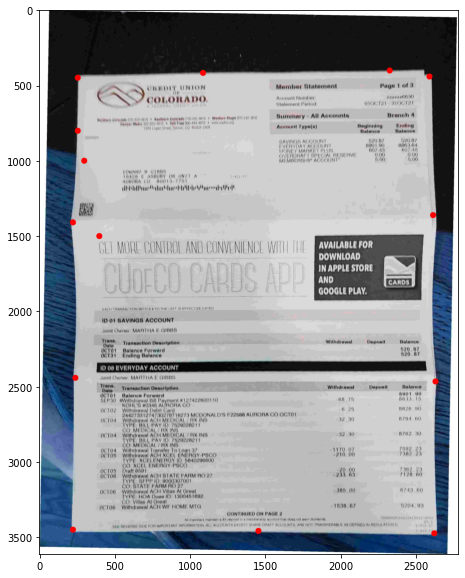

In [180]:
coords = [[257,449], [1089,417], [2329,401], [2593,441], [2617,1361], [2633,2465], [2625,3473],
         [1457,3457], [225,3449], [241,2441], [225,1409], [257,801], [300,1000],[400,1500]]
img = cv2.imread('./eg2_skew.jpg')
image = img.copy()
for center in coords:
    cv2.circle(image, center, 20, (255,0,0), cv2.FILLED)
imgshow(image)

In [4]:
import cv2
import math
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from PIL import Image
import imquality.brisque as brisque
from pdf2image import convert_from_path
import PyPDF2
from pytesseract import Output
import pytesseract
from PIL import Image
import os
import img2pdf
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor #prediction class for detectron2
from detectron2.config import get_cfg #model config file
from detectron2.utils.visualizer import Visualizer #visual utility
from detectron2.data import MetadataCatalog, DatasetCatalog #handling of annotations in image
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.modeling import build_model
from detectron2.utils.visualizer import ColorMode

/data/mmortgage/rotation/rotation_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
register_coco_instances("train", {}, "./CBDI/train.json", "./CBDI/train")
sample_metadata = MetadataCatalog.get("train")

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = './model/'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
predictor = DefaultPredictor(cfg)

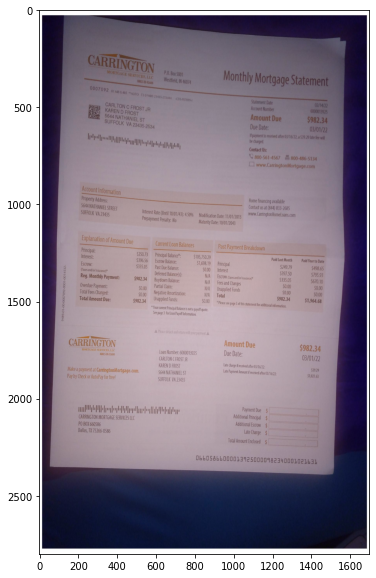

In [736]:
# ./eg8.jpg
# ./eg7.jpg
# ./CBDI/test/05a07df1-7bdd-4c2b-b51b-f81197b135190001-1_corrected.jpg
# ./CBDI/test/Mortgage_Statement_260001-1.jpg

img = cv2.imread('./CBDI/test/Mortgage_Statement_260001-1.jpg')
imgshow(img)

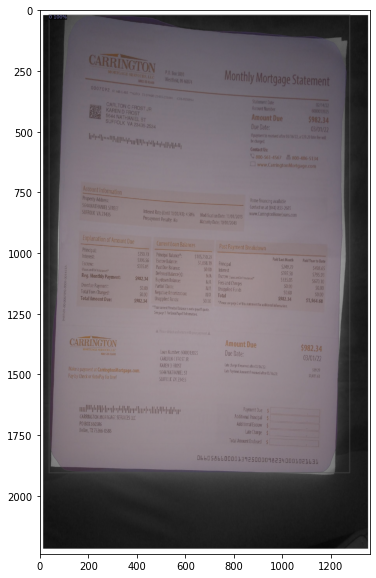

In [737]:
output = predictor(img)
v = Visualizer(img[:, :, ::-1],
               metadata=sample_metadata,
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
imgshow(v.get_image()[:, :, ::-1])

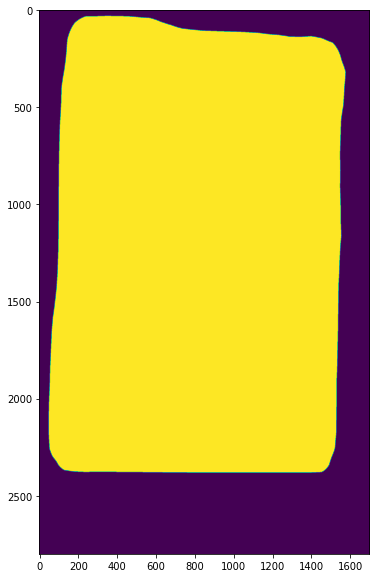

In [738]:
mask = np.int0(output["instances"].to("cpu").pred_masks[0].numpy())
mask= mask*255
imgshow(mask)

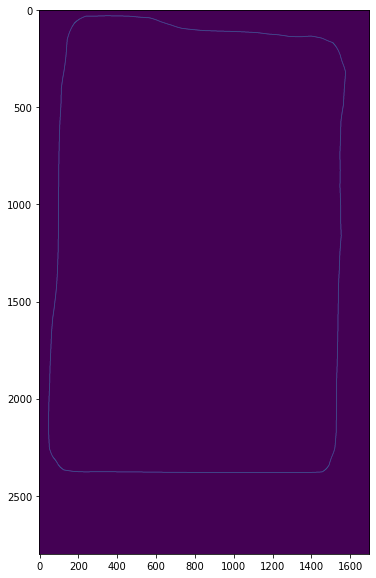

In [739]:
img_edges = cv2.Canny(np.uint8(mask), 100, 100, apertureSize=3)
imgshow(img_edges)

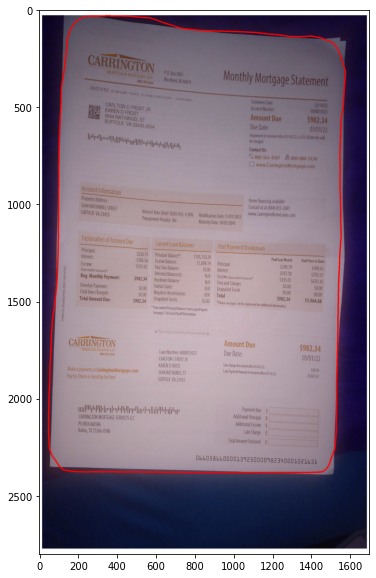

In [740]:
contours, hierarchy = cv2.findContours(img_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image = img.copy()
imgshow(cv2.drawContours(image, contours, -1, (255,0,0), 5))

In [741]:
rotated_rect = cv2.minAreaRect(np.array(contours[0]))
boxpoints = cv2.boxPoints(rotated_rect)
boxpoints = np.int0(boxpoints)
boxpoints

array([[  40, 2372],
       [ 101,   21],
       [1580,   59],
       [1519, 2410]])

In [742]:
import math 
def findNearestPoint(contour, point):
    temp=[]
    x,y = point
    for pts in contour:
        xd,yd = pts
        temp.append(((x - xd)**2 + (y - yd)**2)**0.5)
    return contour[np.argmin(temp)].tolist()

In [743]:
contour = np.reshape(contours[0], (np.shape(contours[0])[0],2))
approx_corners = []
for i in boxpoints:
    approx_corners.append(findNearestPoint(contour, i))
approx_corners = np.int0(approx_corners)
approx_corners

array([[  98, 2340],
       [ 177,   73],
       [1508,  167],
       [1470, 2366]])

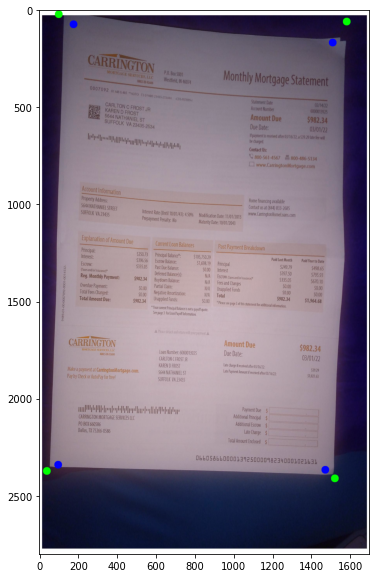

In [744]:
image = img.copy()
for i in range(4):
    cv2.circle(image, approx_corners[i], 20, (0,0,255), cv2.FILLED)
    cv2.circle(image, boxpoints[i], 20, (0,255,0), cv2.FILLED)
imgshow(image)

In [745]:
def order_points_old(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [746]:
approx_corners = order_points_old(approx_corners)
approx_corners = np.int0(approx_corners)
approx_corners

array([[ 177,   73],
       [1508,  167],
       [1470, 2366],
       [  98, 2340]])

In [747]:

def get_destination_points(corners):
    """
    -Get destination points from corners of warped images
    -Approximating height and width of the rectangle: we take maximum of the 2 widths and 2 heights
    Args:
        corners: list
    Returns:
        destination_corners: list
        height: int
        width: int
    """

    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (w - 1, h - 1), (0, h - 1)])
    
    print('\nThe destination points are: \n')
    for index, c in enumerate(destination_corners):
        character = chr(65 + index) + "'"
        print(character, ':', c)
        
    print('\nThe approximated height and width of the original image is: \n', (h, w))
    return destination_corners, h, w

In [748]:
dst = get_destination_points(approx_corners)
dst[0]


The destination points are: 

A' : [0. 0.]
B' : [1371.    0.]
C' : [1371. 2631.]
D' : [   0. 2631.]

The approximated height and width of the original image is: 
 (2632, 1372)


array([[   0.,    0.],
       [1371.,    0.],
       [1371., 2631.],
       [   0., 2631.]], dtype=float32)

In [749]:
approx_corners = np.float32(approx_corners)
approx_corners

array([[ 177.,   73.],
       [1508.,  167.],
       [1470., 2366.],
       [  98., 2340.]], dtype=float32)

In [750]:
w,h = dst[0][2]
w,h = int(w), int(h)
w,h

(1371, 2631)

In [751]:
H, _ = cv2.findHomography(approx_corners, dst[0], method=cv2.RANSAC, ransacReprojThreshold=3.0)
H

array([[ 9.93109494e-01,  3.46076974e-02, -1.78306742e+02],
       [-8.39298052e-02,  1.18841033e+00, -7.18983783e+01],
       [-2.35739480e-05,  1.23177833e-05,  1.00000000e+00]])

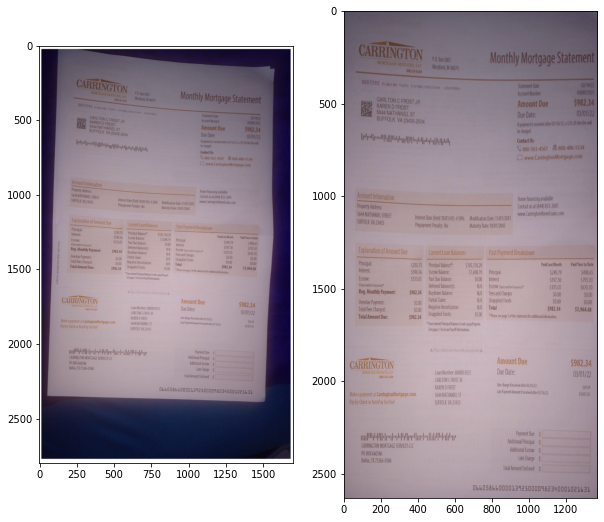

In [752]:
un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(un_warped)